# Neighborhood Vibe Analysis

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans
import nltk
from nltk import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import math as math

## Prerequisite

In [2]:
# download wordnet for future analysis
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xinyueli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Read dataset

In [3]:
df = pd.read_csv('../data/listings_2019.csv')

In [4]:
df.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20190922191643,2019-09-22,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,This is a totally separate apartment located o...,Fully separate apartment in a two apartment bu...,none,"Mostly quiet ( no loud music, no crowed sidewa...",...,f,f,super_strict_30,f,f,2,2,0,0,0.29
1,6976,https://www.airbnb.com/rooms/6976,20190922191643,2019-09-22,Mexican Folk Art Showcase in Boston Neighborhood,Come stay with me in Boston's Roslindale neigh...,"This is a well-maintained, two-family house bu...",Come stay with me in Boston's Roslindale neigh...,none,The LOCATION: Roslindale is a safe and diverse...,...,f,f,moderate,t,f,1,0,1,0,0.67
2,8789,https://www.airbnb.com/rooms/8789,20190922191643,2019-09-22,Curved Glass Studio/1bd facing Park,"Bright, 1 bed with curved glass windows facing...",Fully Furnished studio with enclosed bedroom. ...,"Bright, 1 bed with curved glass windows facing...",none,Beacon Hill is a historic neighborhood filled ...,...,f,f,strict_14_with_grace_period,f,f,10,10,0,0,0.37


## Data Preprocessing

In [5]:
# Extract columns
col = ['id', 'name', 'summary', 'space', 
       'neighborhood_overview', 'transit', 'host_id', 
       'neighbourhood_cleansed', 'latitude', 'longitude']

In [6]:
df = df[col]

In [7]:
df.isnull().sum()

id                           0
name                         1
summary                    141
space                     1426
neighborhood_overview     1789
transit                   1975
host_id                      0
neighbourhood_cleansed       0
latitude                     0
longitude                    0
dtype: int64

In [8]:
df['neighborhood_overview'].fillna('Unknown', inplace=True)

In [9]:
# Examing changes
df.isnull().sum()

id                           0
name                         1
summary                    141
space                     1426
neighborhood_overview        0
transit                   1975
host_id                      0
neighbourhood_cleansed       0
latitude                     0
longitude                    0
dtype: int64

## Build Model

In [10]:
class LemmaTokenizer(object):
    """Custom tokenizer class that stems tokens"""
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in wordpunct_tokenize(doc) if len(t.strip()) > 1]

In [11]:
def show_topn(classifier, vectorizer, categories, n):
    """Returns the top n features that characterize each category"""
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        topn = np.argsort(classifier.coef_[i])[-n:] #sorts in ascending order
        print('{}: {}'.format(category, ", ".join(feature_names[topn])))

In [12]:
def save_topn(classifier, vectorizer, categories, n, outdict):
    """Returns the top n features that characterize eachc category, and save result in outdict"""
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        topn = np.argsort(classifier.coef_[i])[-n:]
        outdict[i] = feature_names[topn]

In [13]:
pipeline = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words='english', tokenizer=LemmaTokenizer())),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, random_state=5)),])


le = LabelEncoder()
new_target = le.fit_transform(df['neighbourhood_cleansed'])
model = pipeline.fit(df['neighborhood_overview'], new_target)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [14]:
# Show top 5 words result
show_topn(model.named_steps['clf'],
          model.named_steps['tfidf'],
          le.inverse_transform(model.named_steps['clf'].classes_), 5)

Allston: greater, greater boston, harvard square, harvard, allston
Back Bay: historic bay, fashionable, shopping, newbury, bay
Bay Village: college, village, marathon, boston marathon, bay village
Beacon Hill: antique, state, hill, beacon hill, beacon
Brighton: college, brighton center, college boston, boston college, brighton
Charlestown: hill monument, monument, bunker, bunker hill, charlestown
Chinatown: rated craft, avery bar, avery, culture, chinatown
Dorchester: savin hill, diverse neighborhood, savin, ashmont, dorchester
Downtown: crossing highlight, downtown crossing, heart downtown, crossing, walk property
East Boston: end old, property le, airport, east, east boston
Fenway: sweet, kenmore, sweet cheek, cheek, fenway
Harbor Islands: community lived, beachfront, beachfront community, point shirley, oriented residential
Hyde Park: street school, school street, quiet family, hyde, hyde park
Jamaica Plain: jp, pond, plain, jamaica plain, jamaica
Leather District: feel privileged, 

## Word Cloud

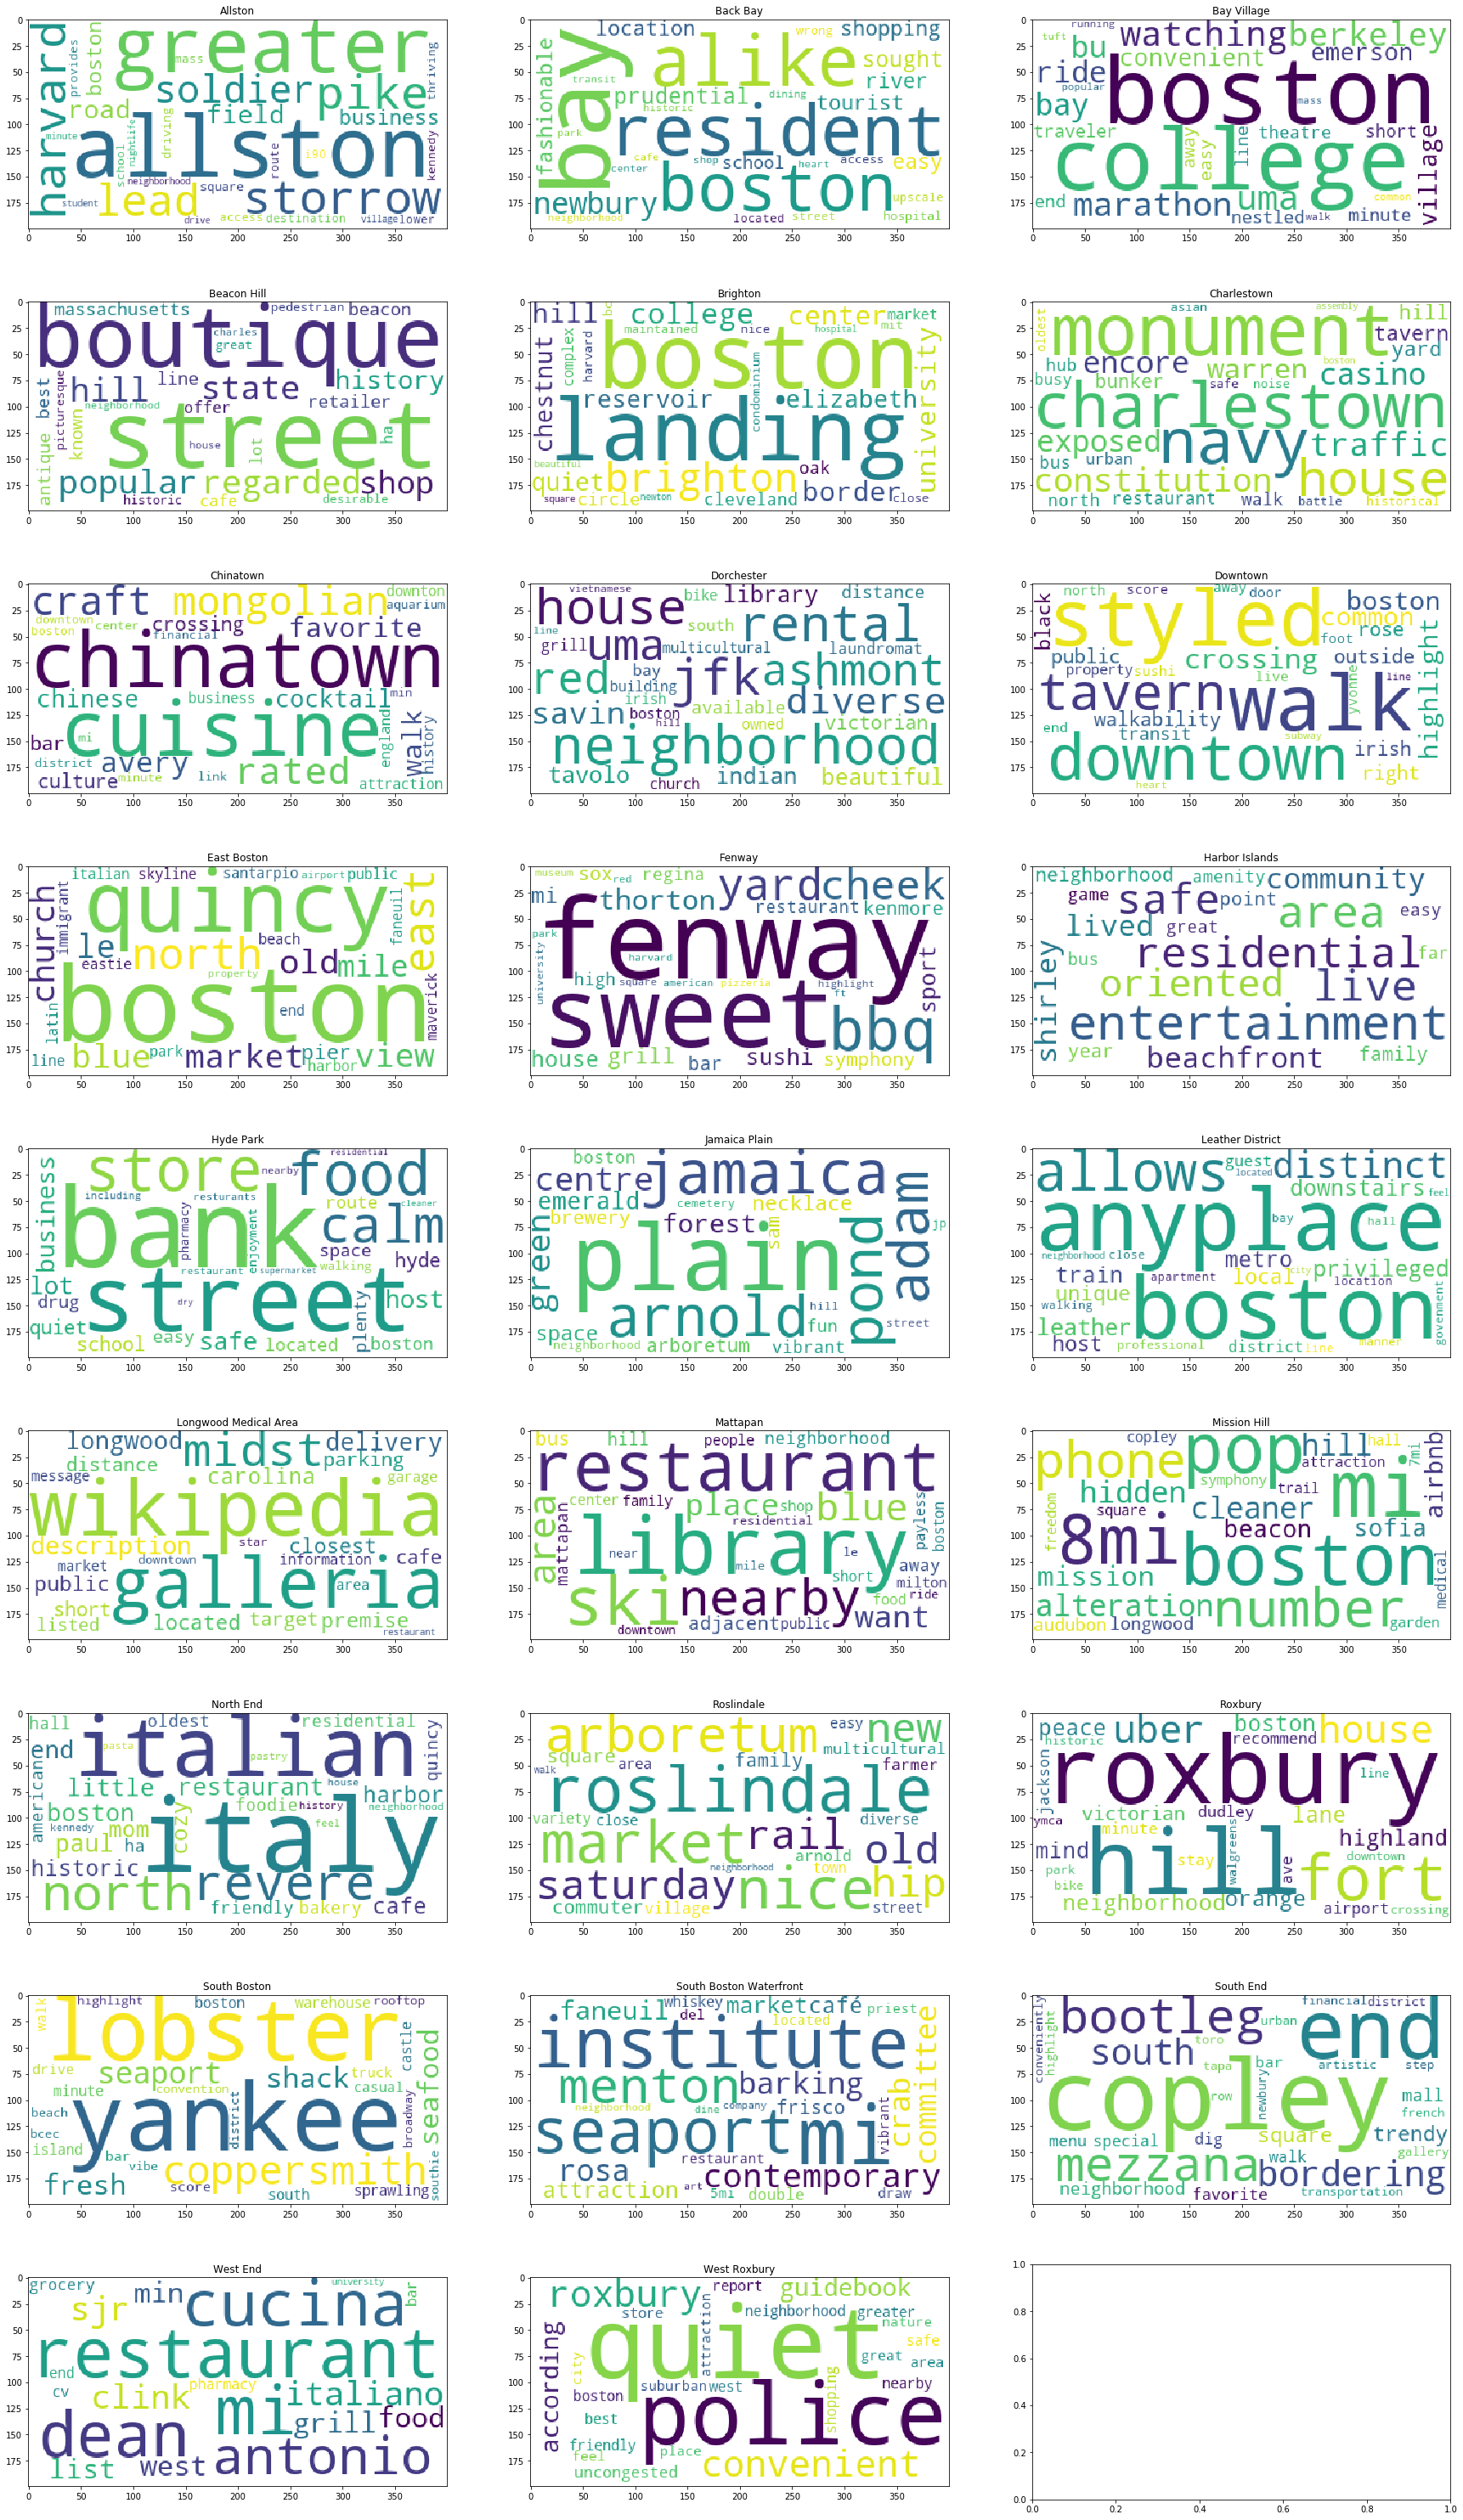

In [17]:
# Create wordcloud based on top-30 words
Keywords = {}
save_topn(model.named_steps['clf'], 
          model.named_steps['tfidf'], 
          le.inverse_transform(model.named_steps['clf'].classes_), 
          30,
          outdict=Keywords)
fig,axes=plt.subplots(9, 3, figsize=(30,54))

# Add title
arr = le.inverse_transform(model.named_steps['clf'].classes_)
cnt = 0
for i in range(len(axes)): 
    for j in range(len(axes[i])):
        if cnt == 26:
            break
        axes[i,j].set_title(arr[cnt])
        cnt += 1
        
for i in range(26):
    wordlist = list(Keywords[i])
    wc = WordCloud(background_color='white', max_words=30, relative_scaling=0.2).generate(" ".join(wordlist))
    print(wc)
    axes[math.floor(i/3),i%3].imshow(wc)